In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Read data from the Excel file
try:
    df = pd.read_excel('Online Retail.xlsx')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: 'Online Retail.xlsx' file not found. Please ensure the file is in the same directory as the notebook.")

Data loaded successfully!


In [2]:
# Check general information about the data (number of rows, columns, data types, missing values)
print("\nGeneral information about the data:")
df.info()

# Check the count of missing values
print("\nNumber of missing values in each column:")
print(df.isnull().sum())

# Handle missing values
df.dropna(subset=['InvoiceNo'], inplace=True)
df.dropna(subset=['CustomerID'], inplace=True)
df.dropna(subset=['Description'], inplace=True)

# Convert CustomerID to integer type
df['CustomerID'] = df['CustomerID'].astype(int)

# Remove cancelled transactions (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Handle negative values in Quantity and UnitPrice (invalid for orders)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# Create a column for the total price of each item in the transaction
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Re-check information after preprocessing
print("\nData information after preprocessing:")
df.info()
print("\nNumber of missing values after preprocessing:")
print(df.isnull().sum())
print("\nFirst 5 rows after preprocessing:")
print(df.head())


General information about the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB

Number of missing values in each column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Data information after preprocessing:
<

In [3]:
# Create a Pivot table (Customer-Item Matrix)
customer_item_matrix = df.pivot_table(index='CustomerID', columns='Description', values='Quantity', aggfunc='sum').fillna(0)

print("\nCustomer-Item Matrix (customer_item_matrix) - First 5x5:")
print(customer_item_matrix.iloc[:5, :5])

# Convert the Customer-Item Matrix into an Item-Customer Matrix
item_customer_matrix = customer_item_matrix.T

print("\nItem-Customer Matrix (item_customer_matrix) - First 5x5:")
print(item_customer_matrix.iloc[:5, :5])

# Calculate Cosine Similarity between items
item_similarity_matrix = cosine_similarity(item_customer_matrix)

# Convert the similarity matrix to a DataFrame for easier handling with product names
item_similarity_df = pd.DataFrame(item_similarity_matrix, index=item_customer_matrix.index, columns=item_customer_matrix.index)

print("\nItem Similarity Matrix (item_similarity_df) - First 5x5:")
print(item_similarity_df.iloc[:5, :5])


Customer-Item Matrix (customer_item_matrix) - First 5x5:
Description  4 PURPLE FLOCK DINNER CANDLES  50'S CHRISTMAS GIFT BAG LARGE  \
CustomerID                                                                  
12346                                  0.0                            0.0   
12347                                  0.0                            0.0   
12348                                  0.0                            0.0   
12349                                  0.0                            0.0   
12350                                  0.0                            0.0   

Description  DOLLY GIRL BEAKER  I LOVE LONDON MINI BACKPACK  \
CustomerID                                                    
12346                      0.0                          0.0   
12347                      0.0                          0.0   
12348                      0.0                          0.0   
12349                      0.0                          0.0   
12350                   

In [5]:
def get_recommendations(product_description, item_similarity_df, num_recommendations=5):
    # Ensure the product exists in the similarity matrix
    if product_description not in item_similarity_df.index:
        print(f"Product '{product_description}' not found in the data. Please check the product name again.")
        return pd.Series([])

    # Get similarity scores of the input product with all other products
    similar_scores = item_similarity_df[product_description]

    # Sort products by similarity score in descending order
    sorted_similar_scores = similar_scores.sort_values(ascending=False)

    # Remove the input product itself from the recommendation list
    # and take the N products with the highest similarity scores
    recommendations = sorted_similar_scores.drop(product_description).head(num_recommendations)

    return recommendations

# --- Section for testing the recommendation system ---

# Get some popular products from the data to test
popular_products = df['Description'].value_counts().head(5).index.tolist()
print("\nPopular products for testing:")
for prod in popular_products:
    print(f"- {prod}")

# Test recommendations for a specific product
# Change the product name here to test different products
product_to_recommend_1 = "JUMBO BAG RED RETROSPOT"
print(f"\n--- Recommendations for product: '{product_to_recommend_1}' ---")
recommendations_1 = get_recommendations(product_to_recommend_1, item_similarity_df, num_recommendations=10)

if not recommendations_1.empty:
    for product, score in recommendations_1.items():
        print(f"- {product} (Similarity: {score:.4f})")
else:
    print("No recommendations found.")

# Test with another product
product_to_recommend_2 = "REGENCY CAKESTAND 3 TIER"
print(f"\n--- Recommendations for product: '{product_to_recommend_2}' ---")
recommendations_2 = get_recommendations(product_to_recommend_2, item_similarity_df, num_recommendations=10)

if not recommendations_2.empty:
    for product, score in recommendations_2.items():
        print(f"- {product} (Similarity: {score:.4f})")
else:
    print("No recommendations found.")
    
#Test recommendations based on a customer's purchase history
num_recommendations = 10
random_customer_id = np.random.choice(customer_item_matrix.index)
print(f"\n--- Checking recommendations for Customer ID: {random_customer_id} ---")

# Get the products that this customer has purchased
products_bought_by_customer = customer_item_matrix.loc[random_customer_id][customer_item_matrix.loc[random_customer_id] > 0].index.tolist()

if not products_bought_by_customer:
    print(f"Customer {random_customer_id} has not purchased any products in the data or data is insufficient.")
else:
    print(f"Products purchased by Customer {random_customer_id} ({len(products_bought_by_customer)} products):")
    # Print the first 5 purchased products for review
    for i, prod in enumerate(products_bought_by_customer[:5]):
        print(f"- {prod}")
    if len(products_bought_by_customer) > 5:
        print(f"... and {len(products_bought_by_customer) - 5} other products.")

    # Create a consolidated list of recommendations from purchased products
    all_customer_recommendations = pd.Series(dtype=float)
    for product in products_bought_by_customer:
        # Get 5 recommendations for each purchased product
        recs = get_recommendations(product, item_similarity_df, num_recommendations=5)
        all_customer_recommendations = pd.concat([all_customer_recommendations, recs])

    # Remove already purchased products from the recommendation list
    # Sort by similarity and remove duplicates to get the final list
    final_customer_recommendations = all_customer_recommendations[~all_customer_recommendations.index.isin(products_bought_by_customer)]
    final_customer_recommendations = final_customer_recommendations.sort_values(ascending=False).drop_duplicates().head(num_recommendations)

    print(f"\nRecommended products for Customer {random_customer_id}:")
    if not final_customer_recommendations.empty:
        for item, score in final_customer_recommendations.items():
            print(f"- {item} (Average Similarity: {score:.4f})")
    else:
        print("No new recommendations found based on this customer's purchase history.")


Popular products for testing:
- WHITE HANGING HEART T-LIGHT HOLDER
- REGENCY CAKESTAND 3 TIER
- JUMBO BAG RED RETROSPOT
- ASSORTED COLOUR BIRD ORNAMENT
- PARTY BUNTING

--- Recommendations for product: 'JUMBO BAG RED RETROSPOT' ---
- JUMBO BAG STRAWBERRY (Similarity: 0.9021)
- JUMBO BAG PINK POLKADOT (Similarity: 0.8974)
- JUMBO BAG OWLS (Similarity: 0.8013)
- JUMBO BAG PINK VINTAGE PAISLEY (Similarity: 0.7886)
- JUMBO BAG APPLES (Similarity: 0.7584)
- JUMBO BAG SCANDINAVIAN BLUE PAISLEY (Similarity: 0.7544)
- JUMBO  BAG BAROQUE BLACK WHITE (Similarity: 0.7505)
- JUMBO BAG SPACEBOY DESIGN (Similarity: 0.7484)
- CHILDRENS CUTLERY RETROSPOT RED  (Similarity: 0.7478)
- JUMBO BAG TOYS  (Similarity: 0.7212)

--- Recommendations for product: 'REGENCY CAKESTAND 3 TIER' ---
- MINI PLAYING CARDS FUN FAIR  (Similarity: 0.7010)
- BOX OF 6 CHRISTMAS CAKE DECORATIONS (Similarity: 0.6990)
- BLACK LOVE BIRD T-LIGHT HOLDER (Similarity: 0.6905)
- MIRROR LOVE BIRD T-LIGHT HOLDER (Similarity: 0.6903)
- 

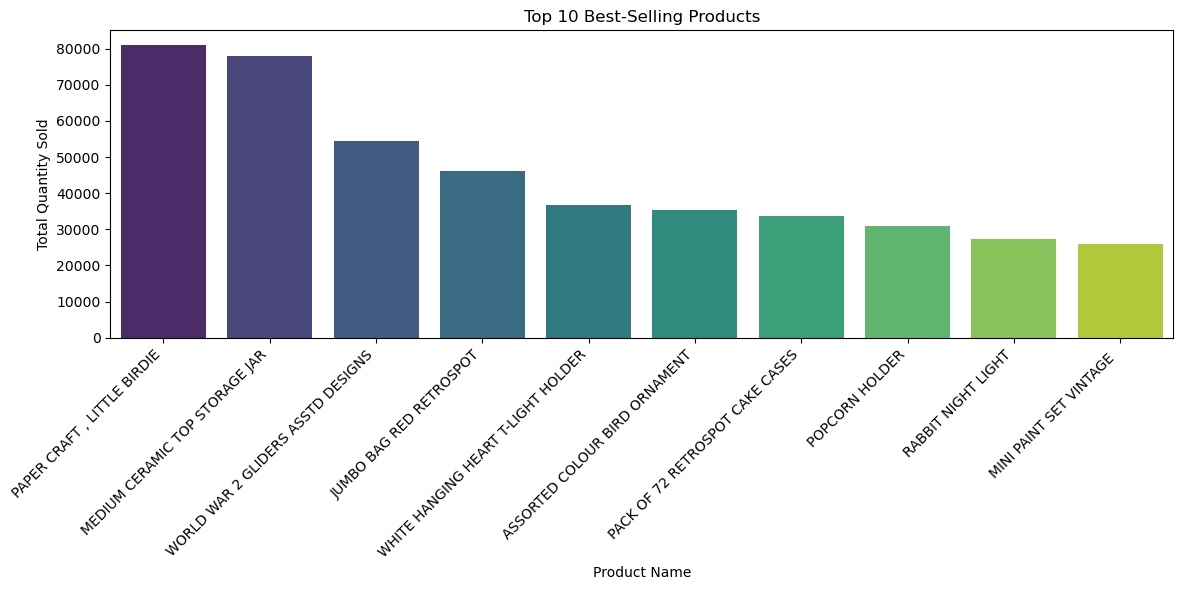

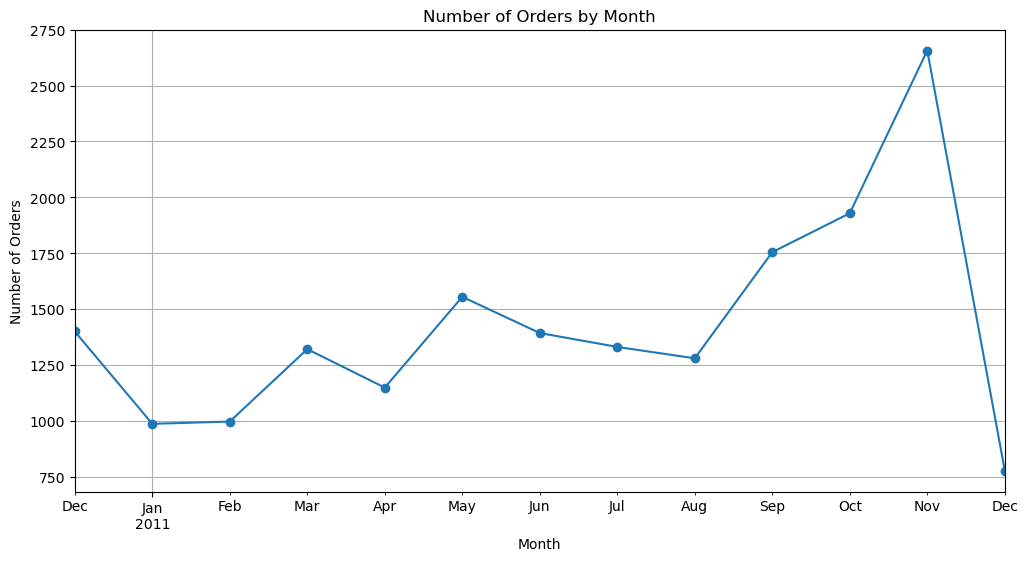

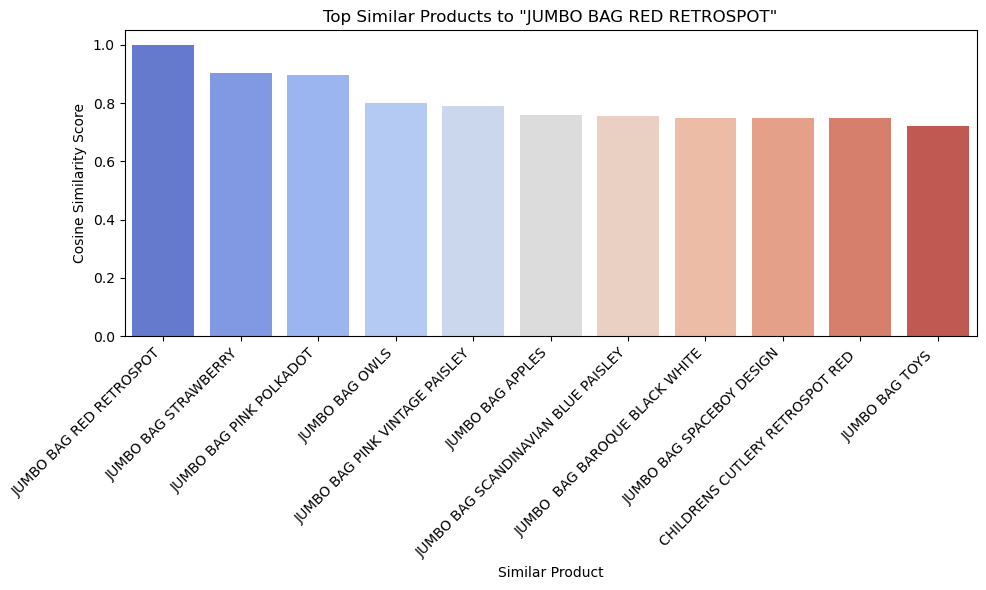

In [6]:
# Visualize the Top 10 Best-Selling Products
top_10_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_products.index, y=top_10_products.values, palette='viridis', hue=top_10_products.index, legend=False)
plt.title('Top 10 Best-Selling Products')
plt.xlabel('Product Name')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()

# Visualize the number of orders by month (to observe seasonal trends if any)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_orders = df.groupby('Month')['InvoiceNo'].nunique()
plt.figure(figsize=(12, 6))
monthly_orders.plot(kind='line', marker='o')
plt.title('Number of Orders by Month')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

# Visualize the similarity of a specific product
product_to_plot_similarity = "JUMBO BAG RED RETROSPOT"
if product_to_plot_similarity in item_similarity_df.index:
    top_similarities = item_similarity_df[product_to_plot_similarity].sort_values(ascending=False).head(11)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_similarities.index, y=top_similarities.values, palette='coolwarm', hue=top_similarities.index, legend=False)
    plt.title(f'Top Similar Products to "{product_to_plot_similarity}"')
    plt.xlabel('Similar Product')
    plt.ylabel('Cosine Similarity Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print(f"\nCould not visualize similarity for product '{product_to_plot_similarity}' as it was not found.")